# Extreme Events EDA

Goals: explore how extreme climate events affect GPP and how plants memorize extreme events and change response moving forward

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore
from sklearn.cluster import KMeans

# Set paths
wd = '/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling/'
data = wd + 'data/datasets/'
hh_data = data + 'half_hourly/'
code = wd + 'code/src/'

### 0. Explore Site Data

In [2]:
# Load one site
site = os.listdir(hh_data)[1]
site_df = pd.read_csv(hh_data + site)
site_name = site.split('_')[-1][:-4]
print(f"Site: {site_name}")
site_df.head()

Site: CN-HaM


,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar


In [11]:
# Check nulls
nulls = site_df.isnull().sum().sort_values(ascending=False)/len(site_df)
nulls[:15]

SW_DIF             1.000000
b6                 0.437618
b5                 0.375236
NDVI               0.364839
EVI                0.364839
b7                 0.364839
b4                 0.364839
b3                 0.364839
b2                 0.364839
b1                 0.364839
NIRv               0.364839
PPFD_IN            0.047397
NETRAD             0.034519
NEE_VUT_REF_qa     0.026800
RECO_DT_CUT_REF    0.000000
dtype: float64

There are two routes to handling nulls for extreme events EDA:
1) Remove all rows with any NA in key feature columns before running analysis
2) Use what you can for each extreme GPP event, and know some info about that event might be missing (**WINNER**)
- This is best because the analysis runs at GPP level and then we check the surrounding predictor vars for extreme GPP events

### 1. GPP Extremes

#### 1.1 Load Site Data, Parse Dates

In [13]:
# Parse start time
def parse_timestamp(timestamp):
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:10])
    mins = int(timestamp[10:12])
    return year, month, day, hour, mins

site_df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINS']] = \
    site_df['TIMESTAMP_START'].astype(str).apply(parse_timestamp).apply(pd.Series)

#### 1.2 Create Season and 4-Hour Time-of-Day Groups

In [64]:
def define_season_tod(predictors, target='GPP_NT_VUT_REF', df=site_df):
    # Season indicator
    df['SEASON'] = ''
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 'WINTER'
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 'SPRING'
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 'SUMMER'
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 'FALL'

    # 6-Hour TOD indicator
    df['TOD_GROUP'] = ''
    df.loc[df['HOUR'].isin(list(range(0, 6))), 'TOD_GROUP'] = '1'
    df.loc[df['HOUR'].isin(list(range(6, 12))), 'TOD_GROUP'] = '2'
    df.loc[df['HOUR'].isin(list(range(12, 18))), 'TOD_GROUP'] = '3'
    df.loc[df['HOUR'].isin(list(range(18, 24))), 'TOD_GROUP'] = '4'

    # Merge to define season-TOD groups
    df['SEASON_TOD'] = df['SEASON'] + '_' + df['TOD_GROUP']

    # Create GPP_extreme indicator to fill in later
    for feat in predictors:
        df['Z_' + feat] = 0
    df['Z_' + target] = 0
    df['EXT_IND_' + target] = 0

    return df


# Apply
predictors = ['TA_ERA', 'P_ERA', 'VPD_ERA', 'SW_IN_ERA', 'NDVI', 'EVI', 'NIRv'] # <--- smaller set for now
target = 'GPP_NT_VUT_REF'
site_df = define_season_tod(predictors, target, site_df)
site_df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,SEASON_TOD,Z_TA_ERA,Z_P_ERA,Z_VPD_ERA,Z_SW_IN_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF,EXT_IND_GPP_NT_VUT_REF
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,WINTER_1,0,0,0,0,0,0,0,0,0
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,WINTER_1,0,0,0,0,0,0,0,0,0


#### 1.3 Get Z-Values for each feature within SEASON_TOD group, identify extreme GPP events (z >= 3 std devs)

In [65]:
def find_extremes(st_group, predictors, target, df=site_df):
    # Subset df to SEASON_TOD group
    subset = df[df['SEASON_TOD']==st_group].copy()

    # Get z-scores for each record within ST group context
    for feat in predictors:
        arr = subset[feat]
        z = arr.copy()
        z[~np.isnan(arr)] = zscore(arr[~np.isnan(arr)]) # handle NANs
        df.loc[list(z.index), 'Z_' + feat] = z

    # Get GPP z-scores and identify extreme events
    arr = subset[target]
    z = arr.copy()
    z[~np.isnan(arr)] = zscore(arr[~np.isnan(arr)]) # handle NANs
    df.loc[list(z.index), 'Z_' + target] = z
    #outliers = np.where(np.abs(z) >= 3)
    outlier_inds = z[np.abs(z) >= 3].index

    # Write GPP outliers to extreme_indicator var
    if len(outlier_inds) > 0:
        df.loc[list(outlier_inds), 'EXT_IND_' + target] = 1

    return df

# Apply
st_groups = site_df['SEASON_TOD'].unique()
for st in st_groups:
    site_df = find_extremes(st, predictors, target, site_df)
site_df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,SEASON_TOD,Z_TA_ERA,Z_P_ERA,Z_VPD_ERA,Z_SW_IN_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF,EXT_IND_GPP_NT_VUT_REF
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.726463,3.473080,-0.922183,NaN,-1.447698,-1.877603,-1.645068,0.508151,0
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.705383,3.473080,-0.891229,NaN,-1.447698,-1.877603,-1.645068,-0.002282,0
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.684302,3.473080,-0.862485,NaN,-1.447698,-1.877603,-1.645068,-0.193739,0
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,WINTER_1,0.663446,-0.173434,-0.833742,NaN,-1.447698,-1.877603,-1.645068,0.956410,0
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,WINTER_1,0.642366,-0.173434,-0.804999,NaN,-1.447698,-1.877603,-1.645068,0.995102,0


#### 1.4 Naive investigation to common trends in extreme events

**QUESTION 1**: Is the average extreme GPP event typically more positive or negative? \
**ANSWER**: More events are negative, and there are more highly negative events than highly positive ones

NEGATIVE    447
POSITIVE    389
Name: EXT_IND_GPP_DIRECTION, dtype: int64


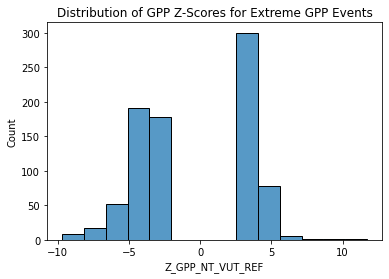

In [70]:
# Is average GPP extreme positive or negative?
site_df['EXT_IND_GPP_DIRECTION'] = np.nan
site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1) & (site_df['Z_GPP_NT_VUT_REF'] >= 3), 'EXT_IND_GPP_DIRECTION'] = 'POSITIVE'
site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1) & (site_df['Z_GPP_NT_VUT_REF'] <= -3), 'EXT_IND_GPP_DIRECTION'] = 'NEGATIVE'
print(site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1), 'EXT_IND_GPP_DIRECTION'].value_counts())

vals = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, 'Z_GPP_NT_VUT_REF']
plt.title('Distribution of GPP Z-Scores for Extreme GPP Events')
sns.histplot(vals)
plt.show()

**QUESTION 2**: Which features are most correlated with extreme GPP event indicator? \
**ANSWER**: All are positive, and small. This isn't the perfect info to tell of what makes up a GPP extreme event

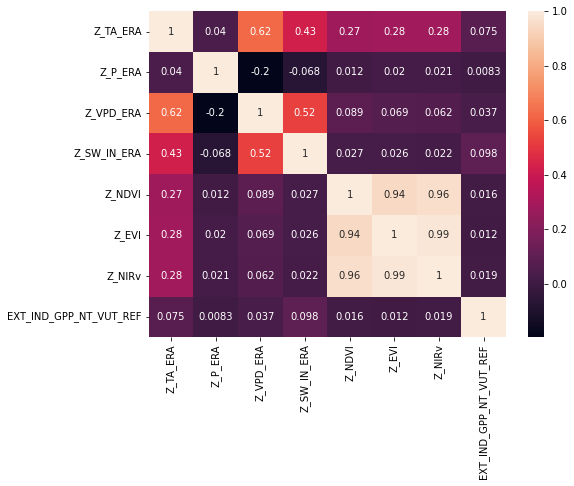

In [71]:
# Which feature is most correlated with GPP extreme events?
corr = site_df[['Z_' + i for i in predictors] + ['EXT_IND_GPP_NT_VUT_REF']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True)
plt.show()

**QUESTION 3**: What does the average GPP event look like in terms of predictor features? \

In [78]:
# Find average Z-score of predictor features for extreme GPP events
site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, ['Z_' + i for i in predictors]].mean().sort_values(ascending=False)

Z_SW_IN_ERA    0.794434
Z_TA_ERA       0.581255
Z_VPD_ERA      0.288860
Z_NIRv         0.138247
Z_NDVI         0.118325
Z_EVI          0.086554
Z_P_ERA        0.064500
dtype: float64

#### 1.5 Cluster extreme events to see common types based on features

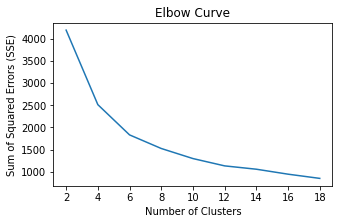

In [82]:
## FIRST, FIND OPTIMAL N_CLUSTERS
# subset to extreme GPP events
clust_feats = ['Z_' + i for i in predictors] + ['Z_GPP_NT_VUT_REF']
ext_gpp = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, clust_feats].copy()
ext_gpp = ext_gpp.dropna(how='any')

def find_elbow_curve(df):
    SSE = []
    for n_clusters in range(2, 20, 2):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        kmeans.fit(df)
        SSE.append(kmeans.inertia_)

    plt.figure(figsize=(5, 3))
    plt.plot(range(2, 20, 2), SSE)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.title("Elbow Curve")
    plt.show()

find_elbow_curve(ext_gpp)

In [86]:
# subset to extreme GPP events
n_clusters = 10

# cluster based on climate vars to find common themes
def k_means(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(df)
    return kmeans.cluster_centers_, kmeans.labels_

centers, labels = k_means(ext_gpp, n_clusters)

# investigate diff clustesr
centers_df = pd.DataFrame(centers, columns=clust_feats)
centers_df.index = ["cluster_" + str(i) for i in range(n_clusters)]
centers_df.sort_values('Z_GPP_NT_VUT_REF', inplace=True)
centers_df.style.background_gradient()
centers_df.style.background_gradient(cmap='RdYlGn')

,Z_TA_ERA,Z_P_ERA,Z_VPD_ERA,Z_SW_IN_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF
cluster_5,-0.292496,0.013622,-0.718731,-0.136702,-1.475258,-1.704394,-1.584578,-4.853330
cluster_8,1.363216,11.799033,-1.088445,-0.246176,1.072502,1.372203,1.438292,-4.125187
cluster_1,1.281853,-0.249407,1.670017,0.545754,0.816067,0.788775,0.847236,-4.041670
cluster_3,0.042557,-0.013808,-0.254681,-0.190180,0.525386,0.508331,0.479848,-3.745130
cluster_7,2.123995,-0.184163,3.325921,2.095935,0.768292,0.719964,0.683099,3.452360
cluster_9,1.004651,0.109320,-0.112977,0.355174,0.975399,1.162299,1.250287,3.504685
cluster_4,1.492261,-0.109039,1.009081,1.969711,1.125043,1.321436,1.426495,3.585567
cluster_2,0.873890,-0.006089,0.143561,0.910197,-1.683624,-1.874917,-1.780624,3.673856
cluster_0,0.254976,4.820619,-1.115575,-0.026988,-0.644618,-0.506106,-0.594132,3.862402
cluster_6,1.785752,0.403525,2.201864,7.488497,1.247243,1.346409,1.524336,3.941117
